In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
from irt import NCFModel, NCF
import torch
import os
device ='cuda:0'
train_data_path = "../data/flickr/processed/train/"
test_data_path = "../data/flickr/processed/test/"
irt_models_path = "../data/flickr/evaluation/irt_models/"
ncf_model_path = "../data/flickr/evaluation/classifier/"
ncf_model_file = "ncf_usrthrs_0.pkl"

/home/gapatron/anaconda3/envs/rebeca-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ncf = NCF()
ncf.load(f"{ncf_model_path}/{ncf_model_file}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
data_test = pd.read_csv(test_data_path+"test_usrthrs_0.csv")
E_test = torch.load(test_data_path+"test_ie_usrthrs_0.pt", weights_only=True)
U_test = torch.tensor(data_test.worker_id)

In [7]:
ncf.score(U_test, E_test.to(torch.float32))

{0: {'avg': 0.11823351681232452, 'std_error': 0.046966902911663055},
 1: {'avg': 0.5654741525650024, 'std_error': 0.07884437590837479},
 2: {'avg': 0.25403016805648804, 'std_error': 0.08045751601457596},
 3: {'avg': 0.4500581622123718, 'std_error': 0.07812011241912842},
 4: {'avg': 0.3693416118621826, 'std_error': 0.09959562867879868},
 5: {'avg': 0.4001348614692688, 'std_error': 0.08583885431289673},
 6: {'avg': 0.4553627371788025, 'std_error': 0.09848164021968842},
 7: {'avg': 0.5372921824455261, 'std_error': 0.09185779839754105},
 8: {'avg': 0.5027067065238953, 'std_error': 0.07565217465162277},
 9: {'avg': 0.15658167004585266, 'std_error': 0.056236736476421356},
 10: {'avg': 0.3388136923313141, 'std_error': 0.08999204635620117},
 11: {'avg': 0.21562743186950684, 'std_error': 0.06562501937150955},
 12: {'avg': 0.4572674632072449, 'std_error': 0.10745872557163239},
 13: {'avg': 0.1430082768201828, 'std_error': 0.054391488432884216},
 14: {'avg': 0.5140448808670044, 'std_error': 0.103

In [8]:
gen_data = torch.load("../data/flickr/evaluation/diffusion_priors/samples/front_cover/front_cover_samples_newzip.pt", weights_only=False)

In [32]:
ncf.model.num_users

210

In [51]:
prior_embeddings = torch.cat([gen_data[i]["prior_embeddings"] for i in range(len(gen_data))], dim=0)
posterior_embeddings = torch.cat([gen_data[i]["posterior_embeddings"] for i in range(len(gen_data))], dim=0)

In [14]:
# I am assuming each user has 10 embeddings, which they do for the front cover samples
u_ids = torch.tensor([i//10 for i in range(prior_embeddings.shape[0])])

In [ ]:
u_ids.shape


torch.Size([2100])

In [57]:
n_perms = 1000
perm_prior_tensor = torch.zeros((n_perms, ncf.model.num_users))
for i in range(n_perms):
    u_perm = u_ids[torch.randperm(u_ids.shape[0])]
    prior_scores = ncf.score(u_perm, prior_embeddings.to(torch.float32))
    perm_avgs = torch.tensor([prior_scores[j]["avg"] for j in prior_scores.keys()])
    perm_prior_tensor[i] = perm_avgs


In [58]:
n_perms = 1000
perm_posterior_tensor = torch.zeros((n_perms, ncf.model.num_users))
for i in range(n_perms):
    u_perm = u_ids[torch.randperm(u_ids.shape[0])]
    posterior_scores = ncf.score(u_perm, posterior_embeddings.to(torch.float32))
    perm_avgs = torch.tensor([posterior_scores[j]["avg"] for j in posterior_scores.keys()])
    perm_posterior_tensor[i] = perm_avgs

In [52]:
real_prior_scores = ncf.score(u_ids, prior_embeddings.to(torch.float32))
real_prior_avgs = torch.tensor([real_prior_scores[i]["avg"] for i in real_prior_scores.keys()])
real_posterior_scores = ncf.score(u_ids, posterior_embeddings.to(torch.float32))
real_posterior_avgs = torch.tensor([real_posterior_scores[i]["avg"] for i in real_posterior_scores.keys()])

In [62]:
perm_prior_means = perm_prior_tensor.mean(dim=1)
perm_prior_medians = perm_prior_tensor.median(dim=1).values
perm_posterior_means = perm_posterior_tensor.mean(dim=1)
perm_posterior_medians = perm_posterior_tensor.median(dim=1).values

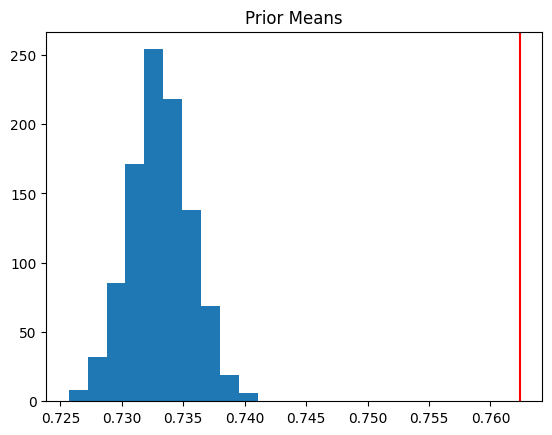

In [67]:
plt.hist(perm_prior_means)
plt.axvline(real_prior_avgs.mean(), color='red')
plt.title("Prior Means")
plt.show()

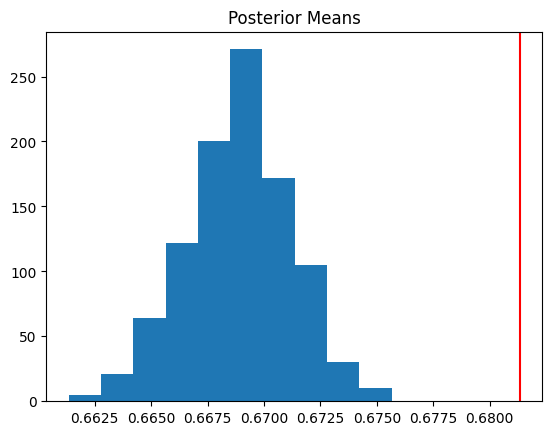

In [66]:
plt.hist(perm_posterior_means)
plt.axvline(real_posterior_avgs.mean(), color='red')
plt.title("Posterior Means")
plt.show()

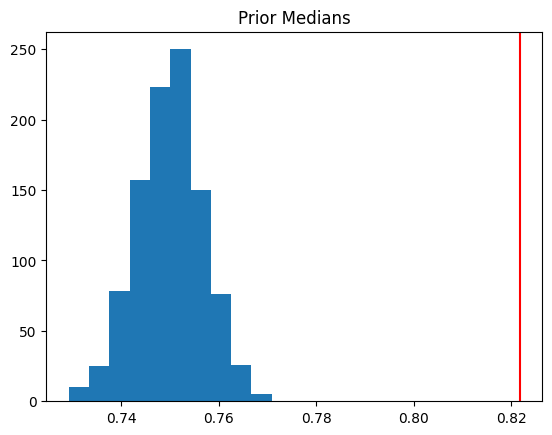

In [68]:
plt.hist(perm_prior_medians)
plt.axvline(real_prior_avgs.median(), color='red')
plt.title("Prior Medians")
plt.show()

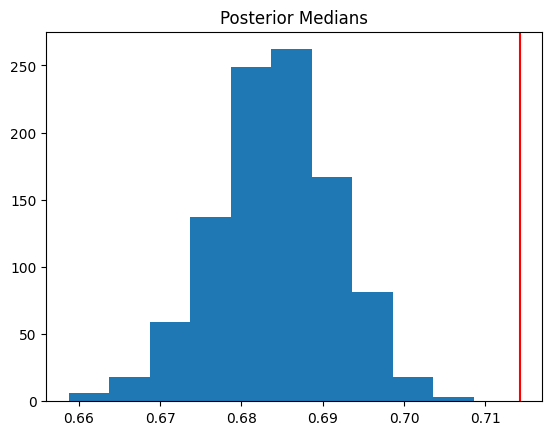

In [69]:
plt.hist(perm_posterior_medians)
plt.axvline(real_posterior_avgs.median(), color='red')
plt.title("Posterior Medians")
plt.show()

In [5]:
PR_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/test"

scores = dict.fromkeys(os.listdir(PR_DIR))

for candidate in os.listdir(PR_DIR):
    if "exp2" not in candidate:
        continue
    print(candidate)
    candidate_dir = os.path.join(PR_DIR, candidate)
    user_scores = dict.fromkeys(os.listdir(candidate_dir))
    for user in os.listdir(candidate_dir):
        
        images_dir = os.path.join(candidate_dir, user, "images")
        sdxl_ipadapter_embs = []
        with torch.no_grad():
            for path in os.listdir(images_dir):
                #path = "../data/raw/FLICKR-AES-001/40K/" + unq_img_path
                impath = os.path.join(images_dir, path)
                pil_image = load_image(impath)
                image_emb = pipe.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
                sdxl_ipadapter_embs.append(image_emb.cpu())
            sdxl_ipadapter_embs_tensor = torch.stack(sdxl_ipadapter_embs)
            torch.save(sdxl_ipadapter_embs_tensor, f"{images_dir}/../embeddings/sdxl_embeddings.pth")

SPU_80_GS_10.0__NEG__usrthrs_100_exp2
SPU_80_GS_12.0__NEG__usrthrs_100_exp2
SPU_80_GS_14.0__NEG__usrthrs_100_exp2
SPU_80_GS_16.0__NEG__usrthrs_100_exp2
SPU_80_GS_18.0__NEG__usrthrs_100_exp2
SPU_80_GS_20.0__NEG__usrthrs_100_exp2
SPU_80_GS_8.0__NEG__usrthrs_100_exp2


In [34]:
from diffusion_adapters import StableDiffusionXLPipelineAdapterEmbeddings, StableDiffusionPipelineAdapterEmbeddings
from diffusers.utils import load_image

pipe = StableDiffusionXLPipelineAdapterEmbeddings.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x1024 and 1280x80)